In [1]:
# Cell 1: 
# Script adapted from http://python4esac.github.io/plotting/specnorm.html
# Start with importing the necessary packages

import sys
import os
import signal
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob

from scipy.interpolate import splrep, splev
from astropy.io import fits

# To ensure interactive plots
from matplotlib import interactive
interactive(True)

%matplotlib notebook

In [2]:
# Cell 2
#
# Defining the necessary functions
#

#def read_ascii(filename):
#    wave, flux, fluxpers = np.loadtxt(filename).T
#    return np.array(wave), np.array(flux), np.array(fluxpers)

def read_ascii(filename):
    wave, flux = np.loadtxt(filename).T
    return np.array(wave), np.array(flux)

def onclick(event):
    # when none of the toolbar buttons is activated and the user clicks in the
    # plot somewhere, compute the median value of the spectrum in a .5 angstrom
    # window around the x-coordinate of the clicked point. The y coordinate
    # of the clicked point is not important. Make sure the continuum points
    # `feel` it when it gets clicked, set the `feel-radius` (picker) to 5 points
    toolbar = plt.get_current_fig_manager().toolbar
    if event.button == 1 and toolbar.mode == '':
        window = ((event.xdata-10.25) <= wave) & (wave <= (event.xdata+10.25))
        y = np.median(flux[window])
        plt.plot(event.xdata, y, 'rs', ms=10, picker=5, label='cont_pnt')
    plt.draw()

def onpick(event):
    # when the user clicks right on a continuum point, remove it
    if event.mouseevent.button == 3:
        if hasattr(event.artist, 'get_label') and event.artist.get_label() == 'cont_pnt':
            event.artist.remove()

def ontype(event):
    # when the user hits enter:
    # 1. Cycle through the artists in the current axes. If it is a continuum
    #    point, remember its coordinates. If it is the fitted continuum from the
    #    previous step, remove it
    # 2. sort the continuum-point-array according to the x-values
    # 3. fit a spline and evaluate it in the wavelength points
    # 4. plot the continuum
    if event.key == 'enter':
        cont_pnt_coord = []
        for artist in plt.gca().get_children():
            if hasattr(artist, 'get_label') and artist.get_label() == 'cont_pnt':
                cont_pnt_coord.append(artist.get_data())
            elif hasattr(artist, 'get_label') and artist.get_label() == 'continuum':
                artist.remove()
        cont_pnt_coord = np.array(cont_pnt_coord)[..., 0]
        sort_array = np.argsort(cont_pnt_coord[:, 0])
        x, y = cont_pnt_coord[sort_array].T
        spline = splrep(x, y, k=3)
        continuum = splev(wave, spline)
        plt.plot(wave, continuum, 'r-', lw=2, label='continuum')

    # when the user hits 'n' and a spline-continuum is fitted, normalise the
    # spectrum
    elif event.key == 'n':
        continuum = None
        for artist in plt.gca().get_children():
            if hasattr(artist, 'get_label') and artist.get_label() == 'continuum':
                continuum = artist.get_data()[1]
                break
        if continuum is not None:
            plt.cla()
            plt.plot(wave, flux/continuum, label='normalised')

    # when the user hits 'r': clear the axes and plot the original spectrum
    elif event.key == 'r':
        plt.cla()
        plt.plot(wave, flux)

    # when the user hits 'w': if the normalised spectrum exists, write it to a
    # file.
    elif event.key == 'w':
        for artist in plt.gca().get_children():
            if hasattr(artist, 'get_label') and artist.get_label() == 'normalised':
                data = np.array(artist.get_data())
                np.savetxt(sftxtnorm, data.T)
                break
    plt.draw()    

<IPython.core.display.Javascript object>


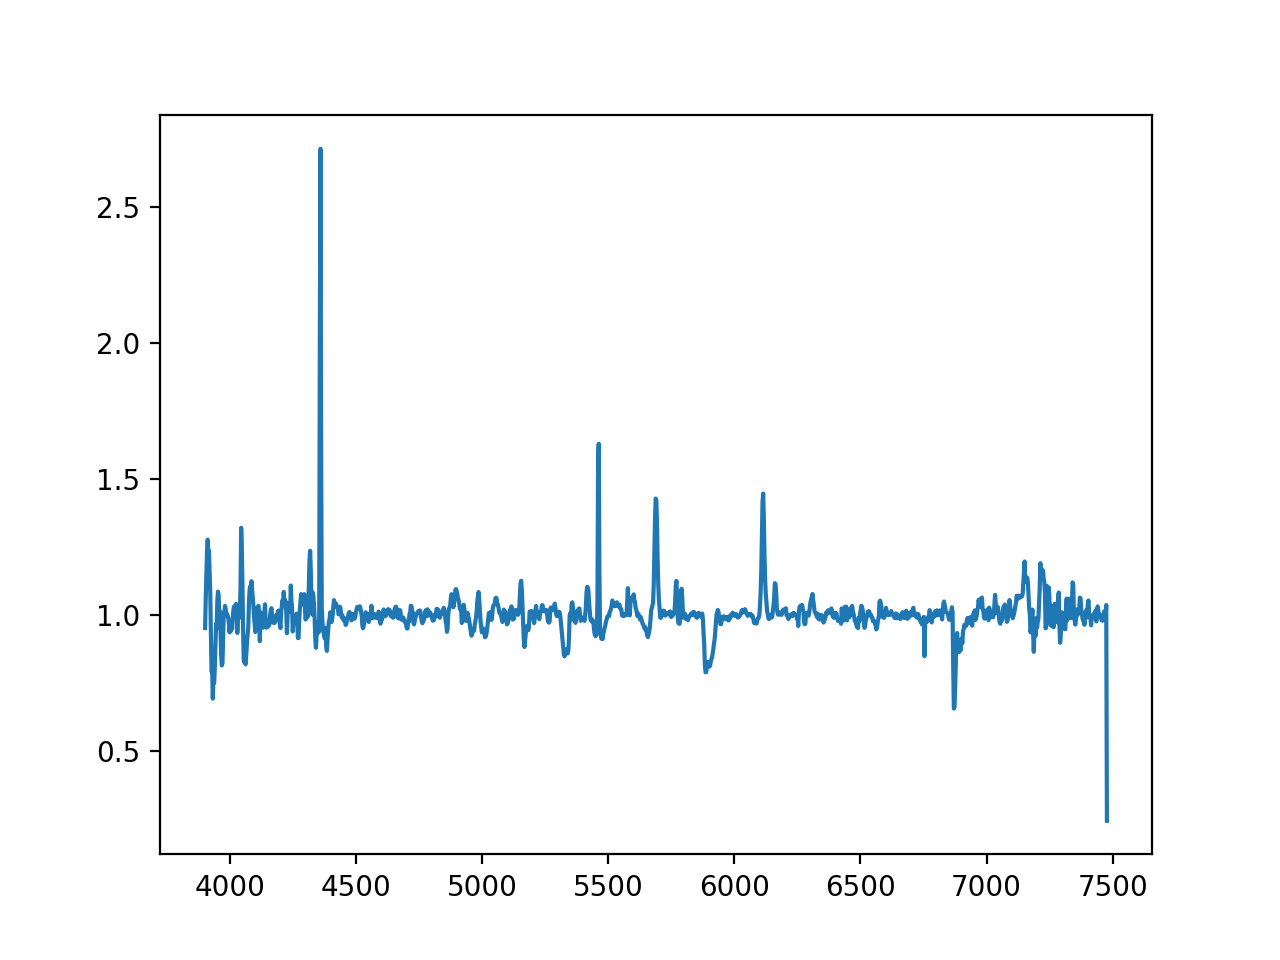

In [4]:
# Cell 3
#
# Read in ascii (.txt) files, plot spectrum and then normalize it
#


# Main data directory (don't use \ in the name, always use /; end with /)
directory = "/Users/nikitasfilosofof/Documents/astronomy-nighttime-run/20220117/" 
sf = "M32_sourcespectrum.txt"
sftxtnorm = directory + sf.replace('.txt', '_norm.txt')

wave, flux = read_ascii(directory + sf)
spectrum = plt.plot(wave, flux)

plt.title(sf)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux')
    
# Connect the different functions to the different events
plt.gcf().canvas.mpl_connect('key_press_event', ontype)
plt.gcf().canvas.mpl_connect('button_press_event', onclick)
plt.gcf().canvas.mpl_connect('pick_event', onpick)
plt.xscale('log')
plt.yscale('log')
plt.show() 